**This notebook belongs to Engin Deniz ALPMAN.**

In [1]:
import torch
import torch.nn as nn
from PIL import Image
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt

import os
import math

In [2]:
import torch.nn.functional as F

In [3]:
PATH= Path("D:/python projects/lectures/102/NN from Scratch/data/mnist")

# Convolutional Neural Network

## Image as a Function

[Link for good illustrations of convolution](https://arxiv.org/abs/1603.07285)

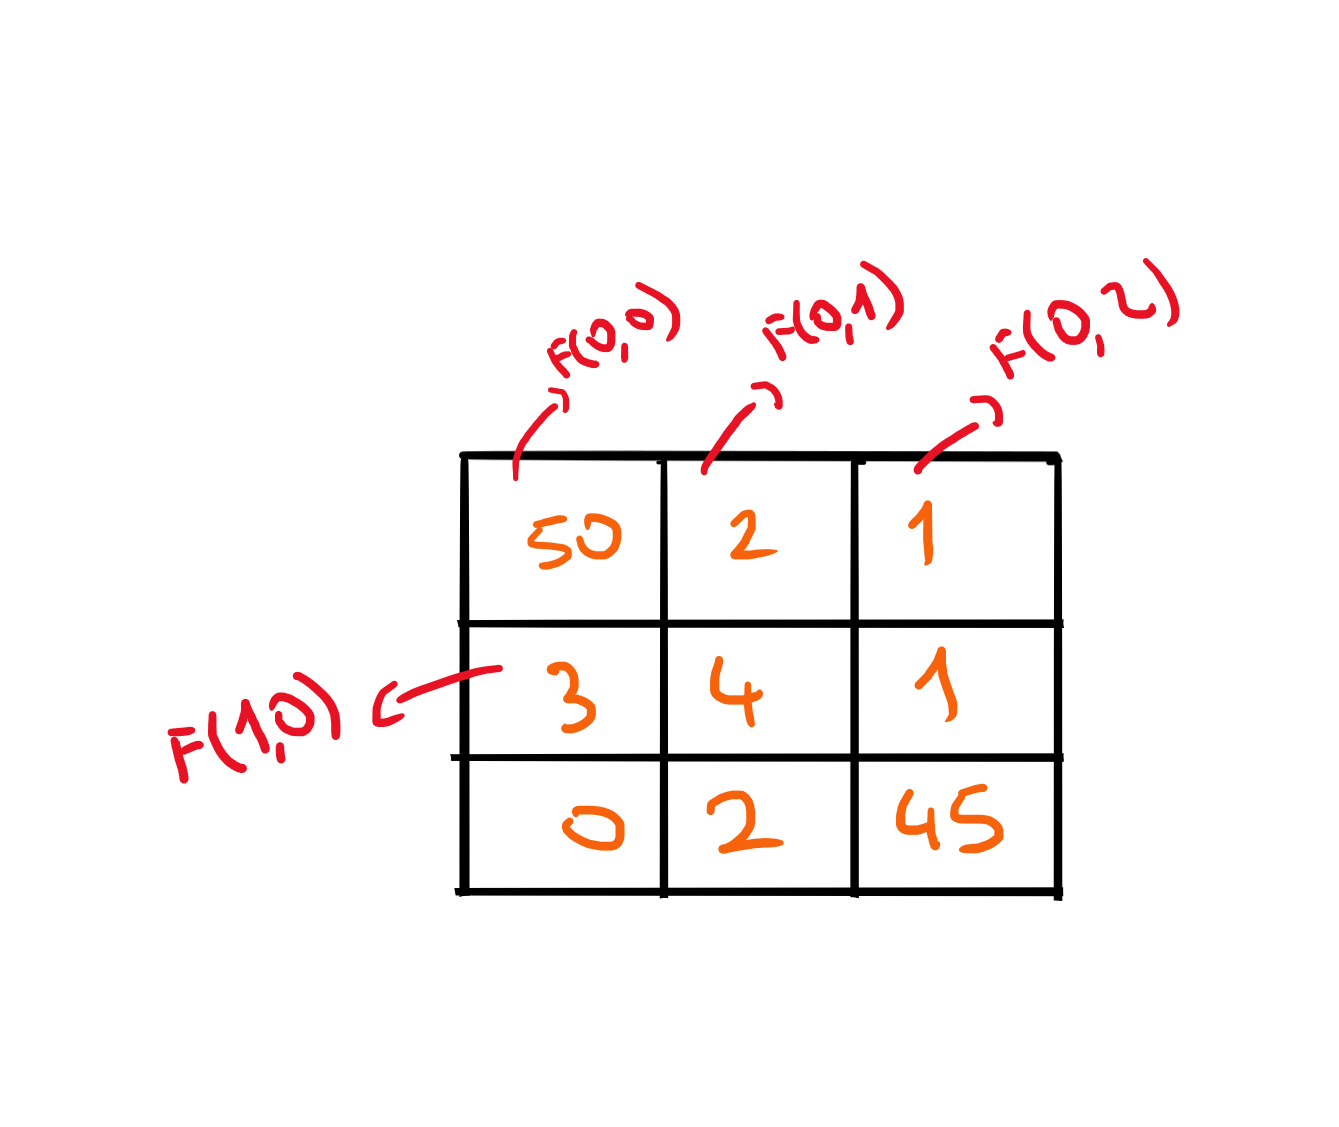

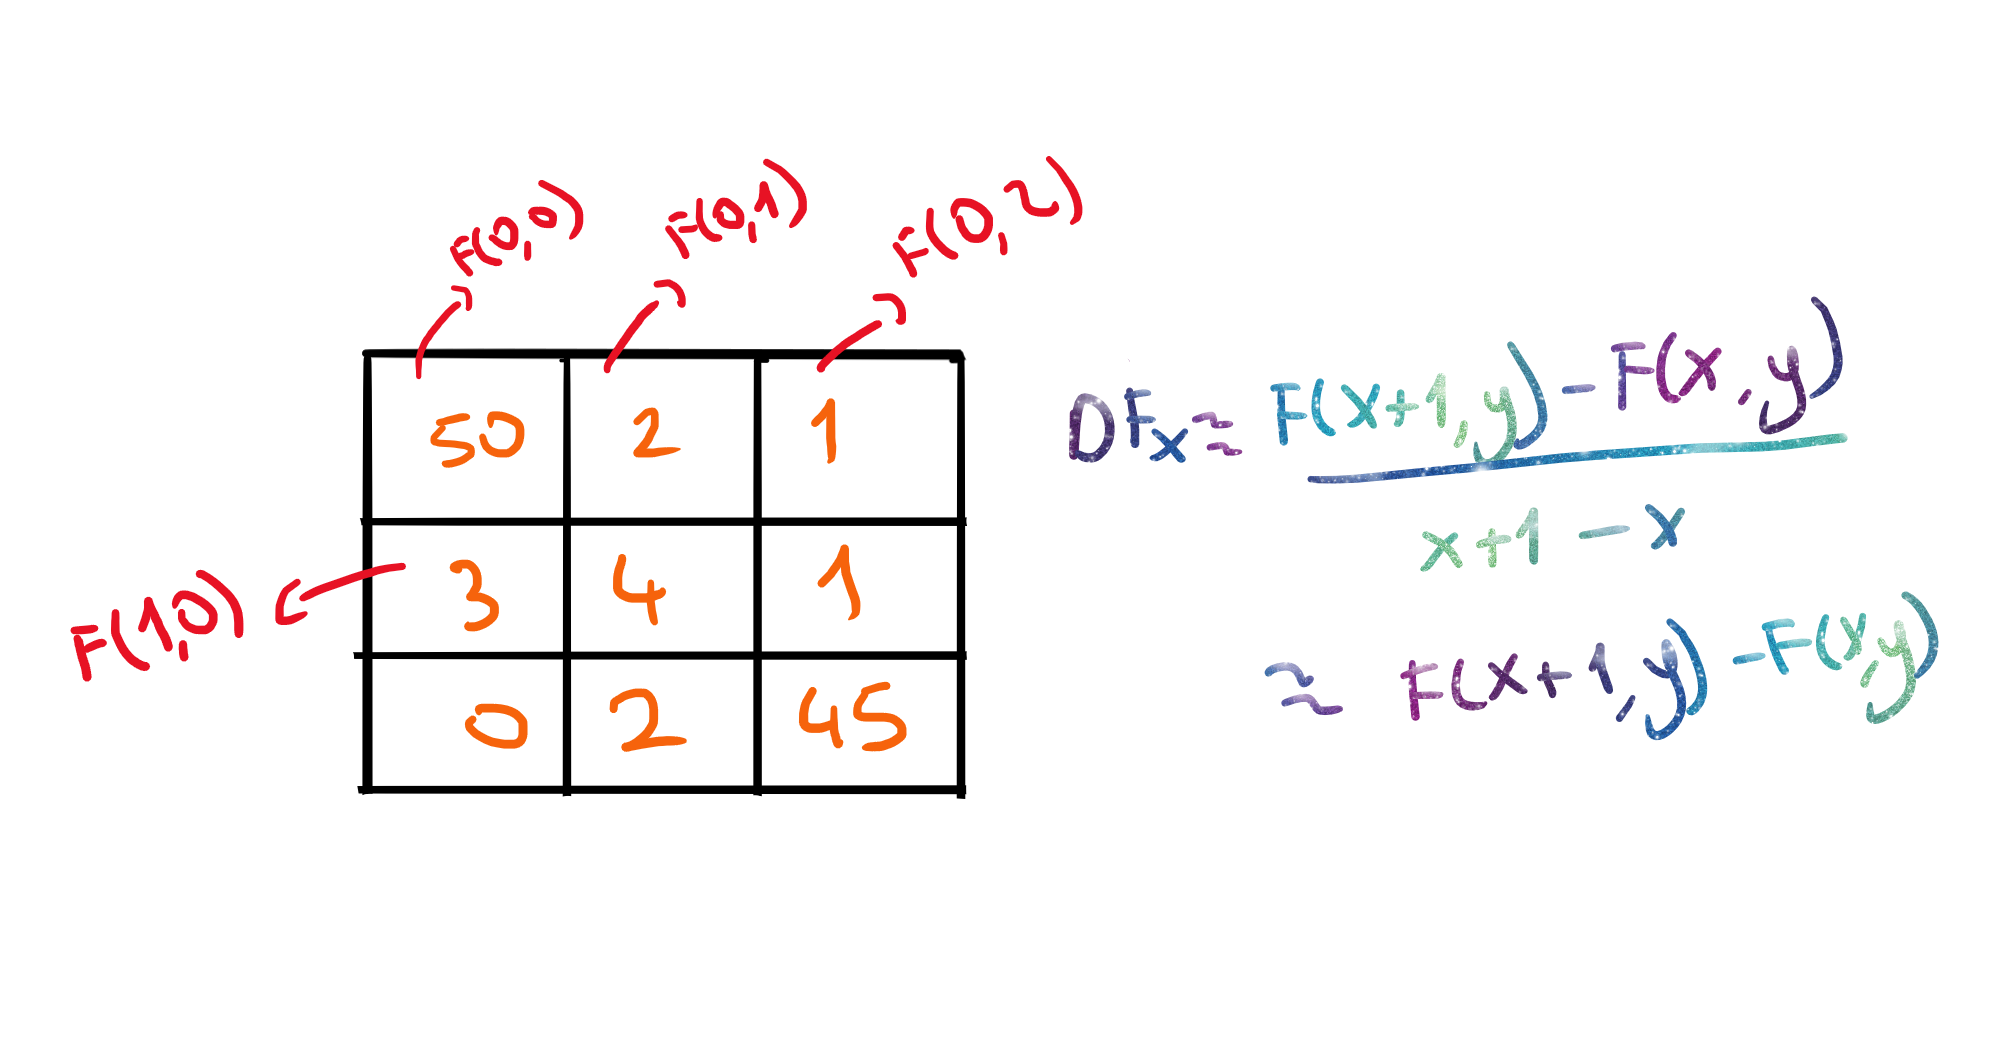

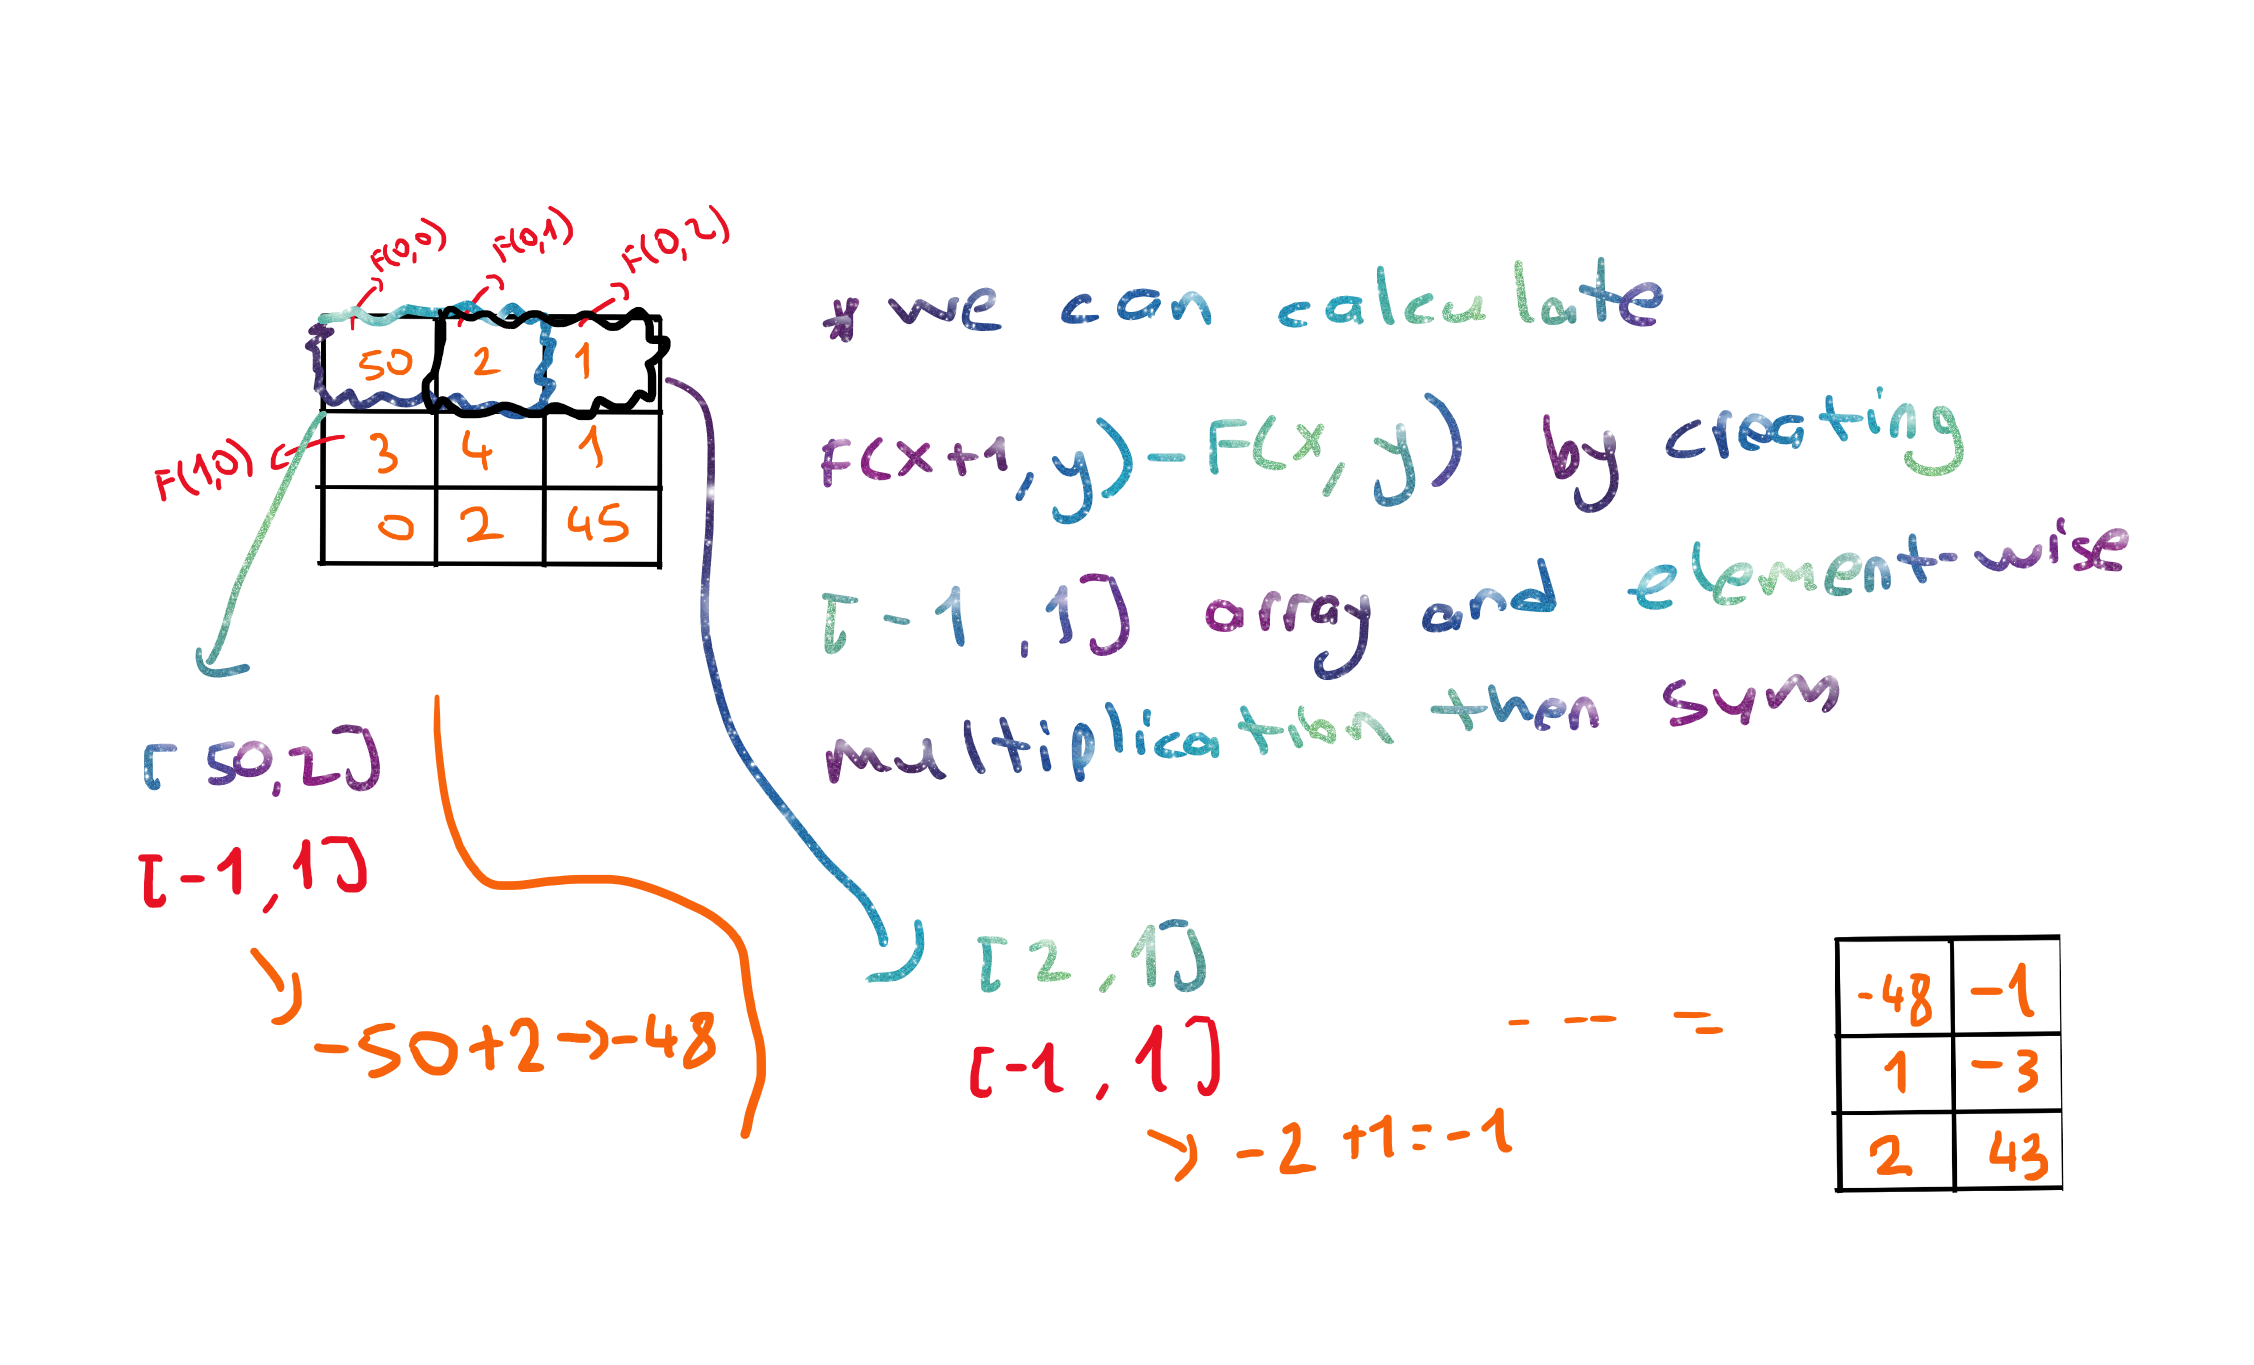

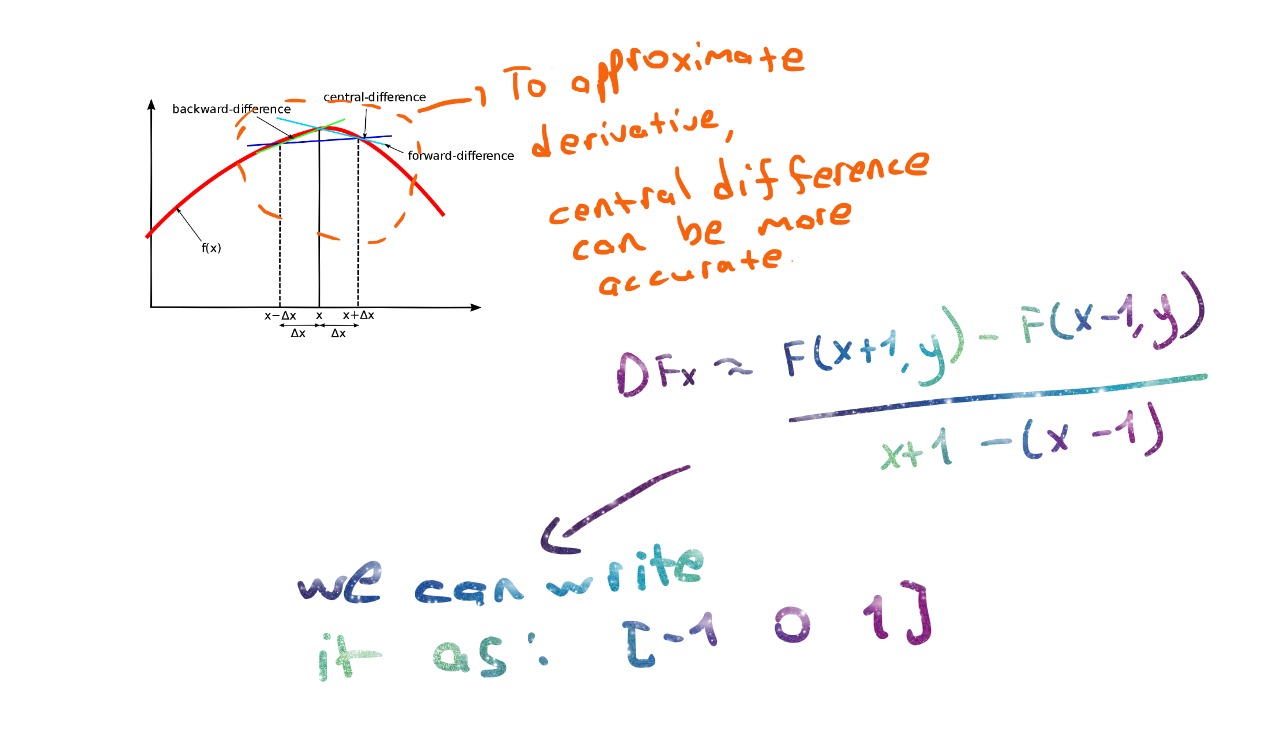

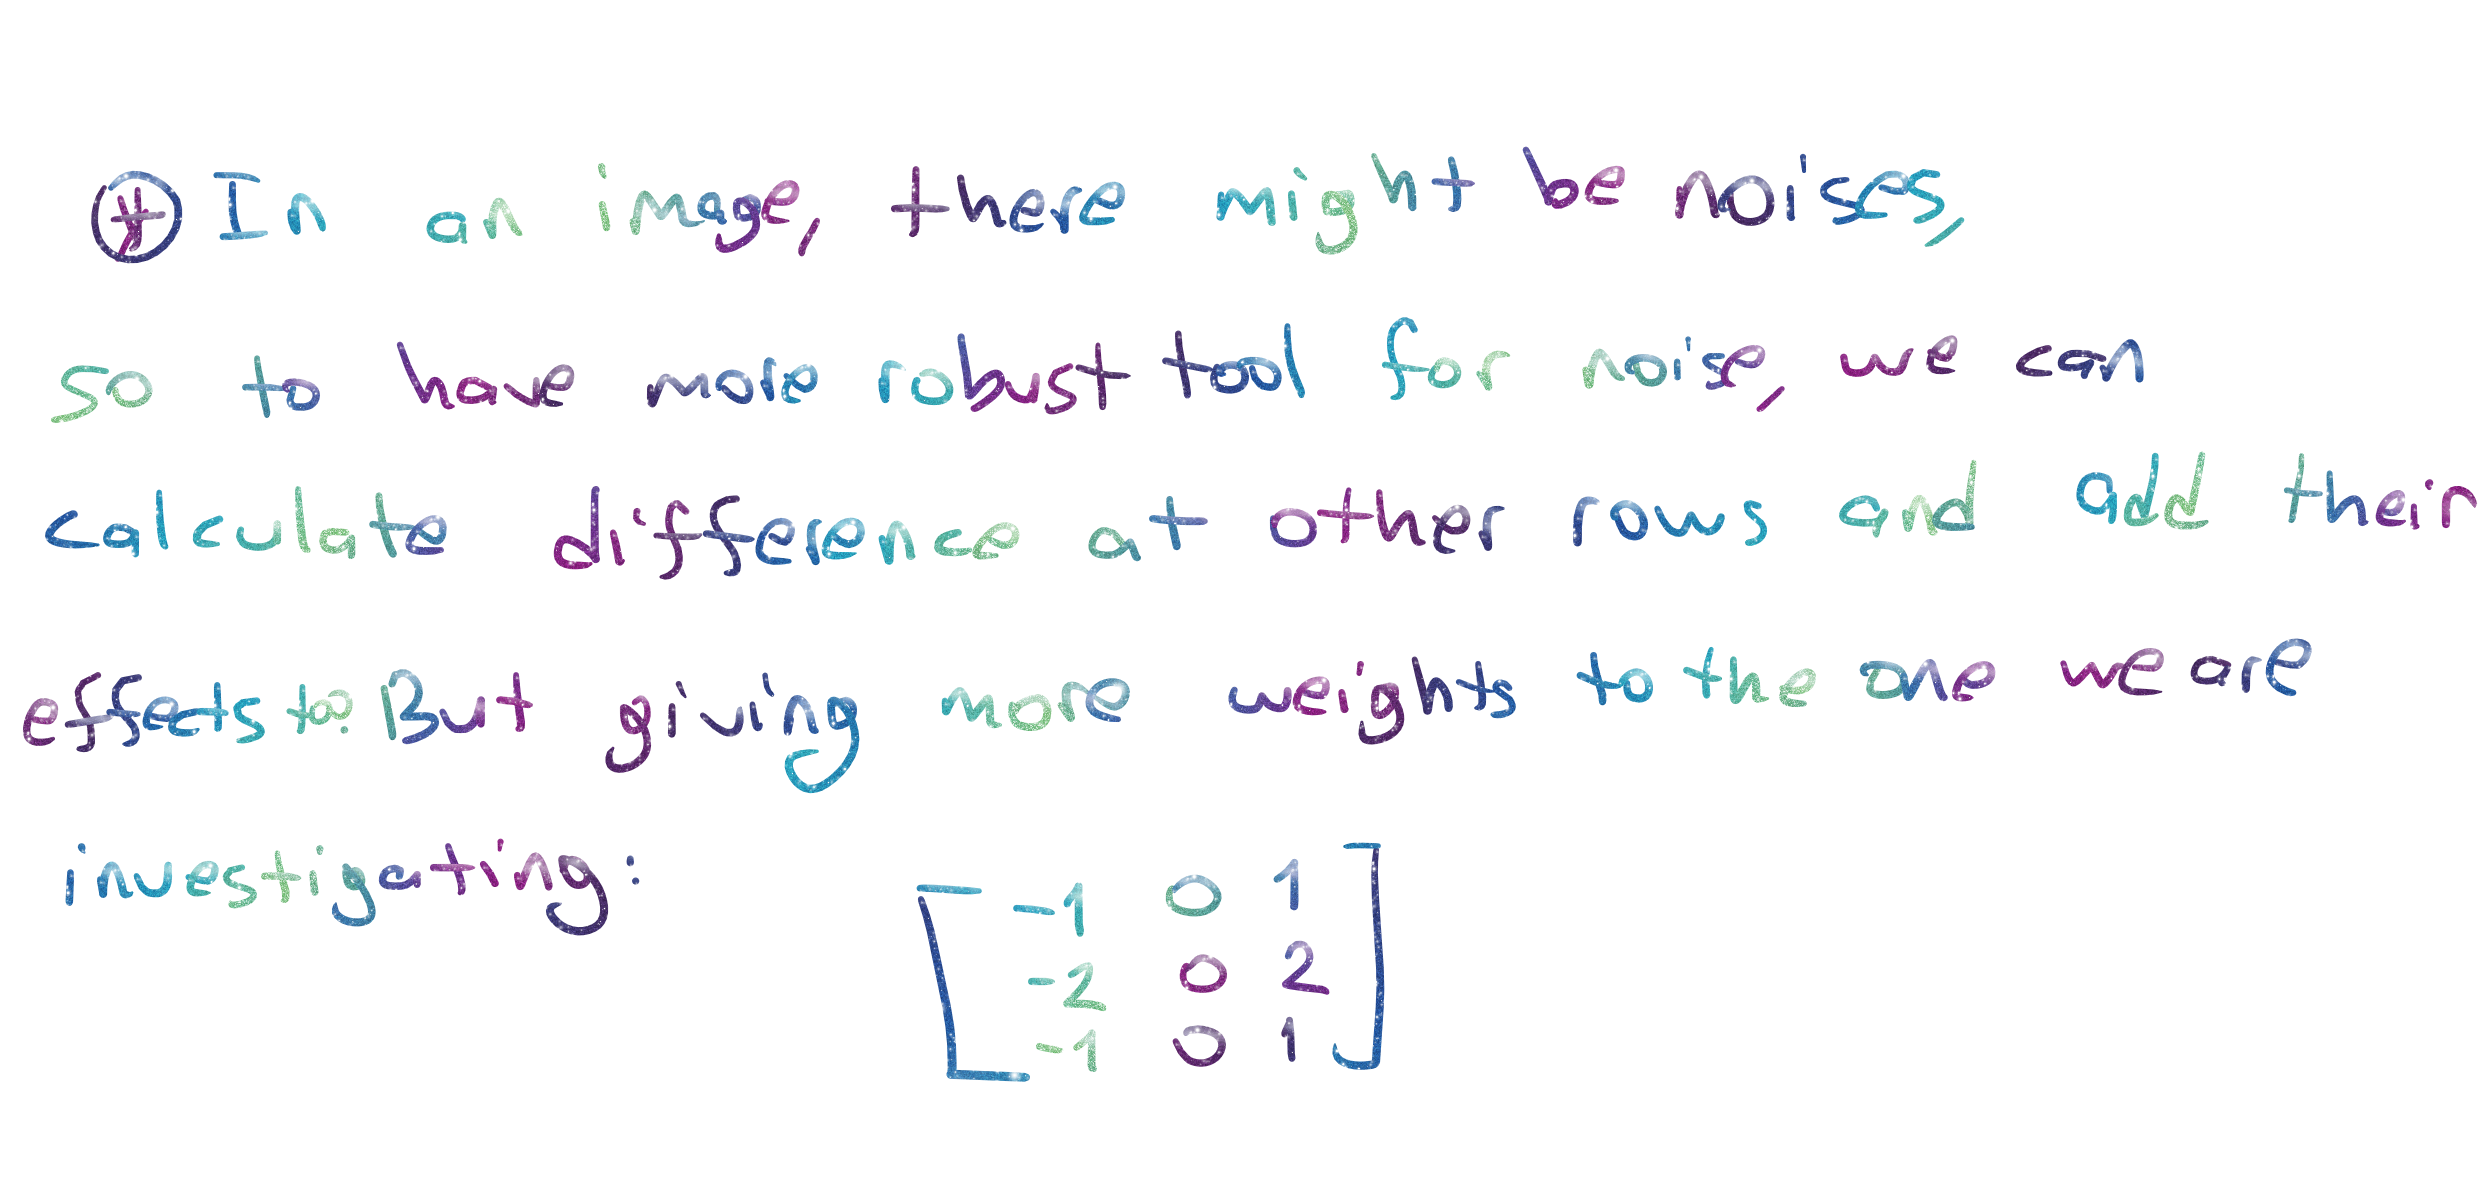

In [12]:
img = np.array(Image.open("img_1.jpg"))

In [13]:
img.shape

(28, 28)

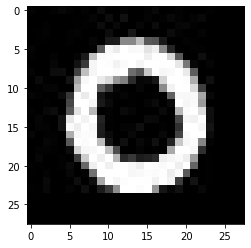

In [14]:
plt.imshow(img, cmap = "gray");

### Creating Kernel

In [20]:
kernel = np.array([-1,1])

In [21]:
out = np.zeros((28,27))

In [138]:
img.shape

(28, 28)

In [39]:
def conv(img, kernel):
    
    out = np.zeros(img.shape)
    img = np.pad(img,[(0, 0), (0, 1)],"edge") # This will do the padding for not to reduce size
    
    for i in range(img.shape[0]):
    
        for j in range(img.shape[1]-1):
            out[i][j] = abs((img[i][j:j+2] * kernel).sum())
    
    return out

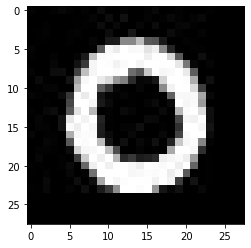

In [40]:
plt.imshow(img, cmap = "gray");

In [41]:
out = conv(img, kernel)

* Remember that all that computer sees are just numbers. So by applying our kernel, we have created new features for our network to learn from.

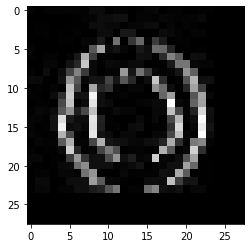

In [42]:
plt.imshow(out, cmap = "gray");

## Feeding New Feature to our Network

In [92]:
def log_softmax(x): 
    return (x.exp()/(x.exp().sum(-1,keepdim=True)) + 1e-20).log()

In [93]:
def nll(preds, actuals): 
    return -preds[range(actuals.shape[0]), actuals].mean()

In [94]:
def validation_acc(model):
    return torch.stack([accuracy(model(xb), yb) for xb, yb in valid_dl]).mean().item()

In [95]:
def accuracy(preds, yb): 
    return (torch.argmax(preds, dim=1, keepdim = True)==yb).float().mean()

In [96]:
def loss_func(preds, targets):
    preds = log_softmax(preds)
    return nll(preds, targets)

In [97]:
def train(model, epochs=5, valid_epoch=5):
    for epoch in range(epochs):
        for xb, yb in train_dl:
            
            preds = model(xb)
            loss = loss_func(preds, yb.squeeze())
            loss.backward()
            optim.step()
            optim.zero_grad()
        
        if epoch % valid_epoch == 0:
            print(validation_acc(model))

In [105]:
def _get_files(p, fs, extensions = None):
    p = Path(p) # to support / notation
    res = [p/f for f in fs if not f.startswith(".") 
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [228]:
class Dataset():
    def __init__(self, x, y): 
        self.x,self.y = x,y
    def __len__(self): 
        return len(self.x)
    def __getitem__(self, i): 
        return self.x[i].cuda(),self.y[i].cuda()


class DataLoader():
    def __init__(self, ds, bs): 
        self.ds, self.bs = ds, bs
    def __iter__(self):
        n = len(self.ds)
        l = torch.randperm(n)

        
        for i in range(0, n, self.bs): 
            idxs_l = l[i:i+self.bs]
            yield self.ds[idxs_l]

### a) Feeding only raw pixels

In [234]:
def create_ds_from_file(src):
    imgs, labels = [], []
    
    for label in range(10):
        path = src/str(label)
        print(path)
        t = [o.name for o in os.scandir(path)]
        t = _get_files(path, t, extensions = [".jpg", ".png"])
        for e in t:
            l = [np.array(Image.open(e)).reshape(28*28)]
            imgs += l
        labels += ([label] * len(t))
    return torch.tensor(imgs,  dtype=torch.float32), torch.tensor(labels, dtype=torch.long).view(-1,1)

In [235]:
trn_x, trn_y = create_ds_from_file(PATH/"train")

D:\python projects\lectures\102\NN from Scratch\data\mnist\train\0
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\1
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\2
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\3
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\4
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\5
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\6
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\7
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\8
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\9


In [236]:
val_x,val_y = create_ds_from_file(PATH/"validation")

D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\0
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\1
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\2
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\3
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\4
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\5
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\6
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\7
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\8
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\9


In [237]:
mean = trn_x.mean()
std = trn_x.std()

trn_x=(trn_x-mean)/std
mean, std, trn_x.mean(), trn_x.std()

(tensor(34.3409), tensor(77.5014), tensor(7.4670e-06), tensor(1.))

In [238]:
val_x = (val_x-mean)/std
val_x.mean(), val_x.std()

(tensor(0.0042), tensor(1.0038))

In [239]:
train_ds = Dataset(trn_x, trn_y)
valid_ds = Dataset(val_x,val_y)

In [240]:
train_dl = DataLoader(train_ds, 256)
valid_dl = DataLoader(valid_ds, 256)

In [241]:
model = nn.Sequential(
    nn.Linear(784,60),
    nn.ReLU(),
    nn.Linear(60,10)
).cuda()

In [242]:
optim = torch.optim.SGD(model.parameters(), lr=0.001)

In [243]:
train(model,50,5)

0.27534520626068115
0.6988554000854492
0.8095021843910217
0.8400254249572754
0.8614643812179565
0.8692768812179565
0.8761809468269348
0.8832666873931885
0.8849018812179565
0.890079915523529


### Question:

* Why doing that at every batch slows down our progress ?

In [196]:
def conv_batch(img, kernel):
    
    
    img = img.view(-1,28,28)
    out = torch.zeros(img.shape)
    
    for i in range(img.shape[0]):
        img_temp = np.pad(img[i],[(0, 0), (0, 1)],"edge")
        for j in range(img.shape[1]):

            for k in range(img.shape[2]-1):
                out[i][j][k] = abs((img_temp[j][k:k+2] * kernel).sum())
    
    return out.view(-1, 784)

In [197]:
class Dataset():
    def __init__(self, x, y): 
        self.x,self.y = x,y
    def __len__(self): 
        return len(self.x)
    def __getitem__(self, i): 
        return conv_batch(self.x[i], kernel).cuda(),self.y[i].cuda()


class DataLoader():
    def __init__(self, ds, bs): 
        self.ds, self.bs = ds, bs
    def __iter__(self):
        n = len(self.ds)
        l = torch.randperm(n)

        
        for i in range(0, n, self.bs): 
            idxs_l = l[i:i+self.bs]
            yield self.ds[idxs_l]

### b) Feeding Features we extracted with edge detection

In [244]:
def create_ds_from_file(src):
    imgs, labels = [], []
    
    for label in range(10):
        path = src/str(label)
        print(path)
        t = [o.name for o in os.scandir(path)]
        t = _get_files(path, t, extensions = [".jpg", ".png"])
        for e in t:
            l = [conv(np.array(Image.open(e)), kernel).reshape(28*28)]
            imgs += l
        labels += ([label] * len(t))
    return torch.tensor(imgs,  dtype=torch.float32), torch.tensor(labels, dtype=torch.long).view(-1,1)

In [245]:
trn_x, trn_y = create_ds_from_file(PATH/"train")

D:\python projects\lectures\102\NN from Scratch\data\mnist\train\0
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\1
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\2
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\3
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\4
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\5
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\6
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\7
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\8
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\9


In [246]:
val_x,val_y = create_ds_from_file(PATH/"validation")

D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\0
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\1
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\2
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\3
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\4
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\5
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\6
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\7
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\8
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\9


In [253]:
mean = trn_x.mean()
std = trn_x.std()

trn_x=(trn_x-mean)/std
mean, std, trn_x.mean(), trn_x.std()

(tensor(18.2785), tensor(44.2487), tensor(3.7285e-07), tensor(1.))

In [254]:
val_x = (val_x-mean)/std
val_x.mean(), val_x.std()

(tensor(0.0030), tensor(1.0022))

In [255]:
train_ds = Dataset(trn_x, trn_y)
valid_ds = Dataset(val_x,val_y)

In [256]:
train_dl = DataLoader(train_ds, 256)
valid_dl = DataLoader(valid_ds, 256)

In [260]:
model = nn.Sequential(
    nn.Linear(784,60),
    nn.ReLU(),
    nn.Linear(60,10)
).cuda()

In [261]:
optim = torch.optim.SGD(model.parameters(), lr=0.01)

In [262]:
train(model,50,5)

0.6881359219551086
0.8743640780448914
0.8981649875640869
0.9066133499145508
0.9082485437393188
0.9139716625213623
0.9155159592628479
0.9168786406517029
0.9212390780448914
0.9198764562606812


* It has improved, so feeding only new feature probably make it easy for our network to learn !

* Now we will try to feed both raw pixel images and edge features together (spoiler, it will be very similar to cnn's linear layer connection)

### c) Feeding both features we extracted with edge detection and raw pixel images

In [263]:
def create_ds_from_file(src):
    imgs, labels = [], []
    
    for label in range(10):
        path = src/str(label)
        print(path)
        t = [o.name for o in os.scandir(path)]
        t = _get_files(path, t, extensions = [".jpg", ".png"])
        for e in t:
            img = np.array(Image.open(e))
            l = [np.concatenate((conv(img, kernel).reshape(-1), img.reshape(-1)))]
            imgs += l
        labels += ([label] * len(t))
    return torch.tensor(imgs,  dtype=torch.float32), torch.tensor(labels, dtype=torch.long).view(-1,1)

In [264]:
trn_x, trn_y = create_ds_from_file(PATH/"train")

D:\python projects\lectures\102\NN from Scratch\data\mnist\train\0
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\1
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\2
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\3
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\4
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\5
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\6
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\7
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\8
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\9


In [265]:
val_x,val_y = create_ds_from_file(PATH/"validation")

D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\0
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\1
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\2
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\3
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\4
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\5
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\6
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\7
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\8
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\9


In [266]:
# there is little error here, can you spot it ?
mean = trn_x.mean()
std = trn_x.std()

trn_x=(trn_x-mean)/std
mean, std, trn_x.mean(), trn_x.std()

(tensor(26.3097), tensor(63.6137), tensor(-7.9945e-05), tensor(1.))

In [267]:
val_x = (val_x-mean)/std
val_x.mean(), val_x.std()

(tensor(0.0036), tensor(1.0036))

In [268]:
train_ds = Dataset(trn_x, trn_y)
valid_ds = Dataset(val_x,val_y)

In [269]:
train_dl = DataLoader(train_ds, 256)
valid_dl = DataLoader(valid_ds, 256)

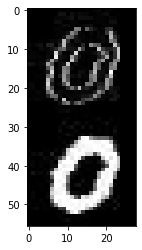

In [275]:
plt.imshow(trn_x[0].view(56,28), cmap = "gray");

In [276]:
model = nn.Sequential(
    nn.Linear(56*28,60),
    nn.ReLU(),
    nn.Linear(60,10)
).cuda()

In [277]:
optim = torch.optim.SGD(model.parameters(), lr=0.01)

In [278]:
train(model,50,5)

0.8542878031730652
0.9255087375640869
0.9396802186965942
0.9441315531730652
0.9484919905662537
0.9503996968269348
0.9546693563461304
0.9563044905662537
0.9589389562606812
0.9582121968269348


* Wow it has improved alot ! So adding edge feature helped our model !

* In this Lecture we will use convolutional network as feature extractor, as we are pushing it with loss function, it will learn how to extract important features for our task

## Convolutional Neural Network (CNN)

* We saw that adding feature that we extracted from image can help our model to learn better. 

* But there is a problem. There is a infinitely many kernel that we can apply to extract feature, how can we know that we are applying optimal one?

* Hmm, but if kernels only consist of numbers, and if those numbers are interacting with our inputs.. Wait a minute ! This sounds familiar ! It is very similar to weights on vanilla neural network. So we will let our network to decide which numbers it will put in kernel to extract more helpful features for predictions

* Our predictions are dependent on those feature extraction steps, so our network will adjust them to make less error by going in the opposite direction of gradient

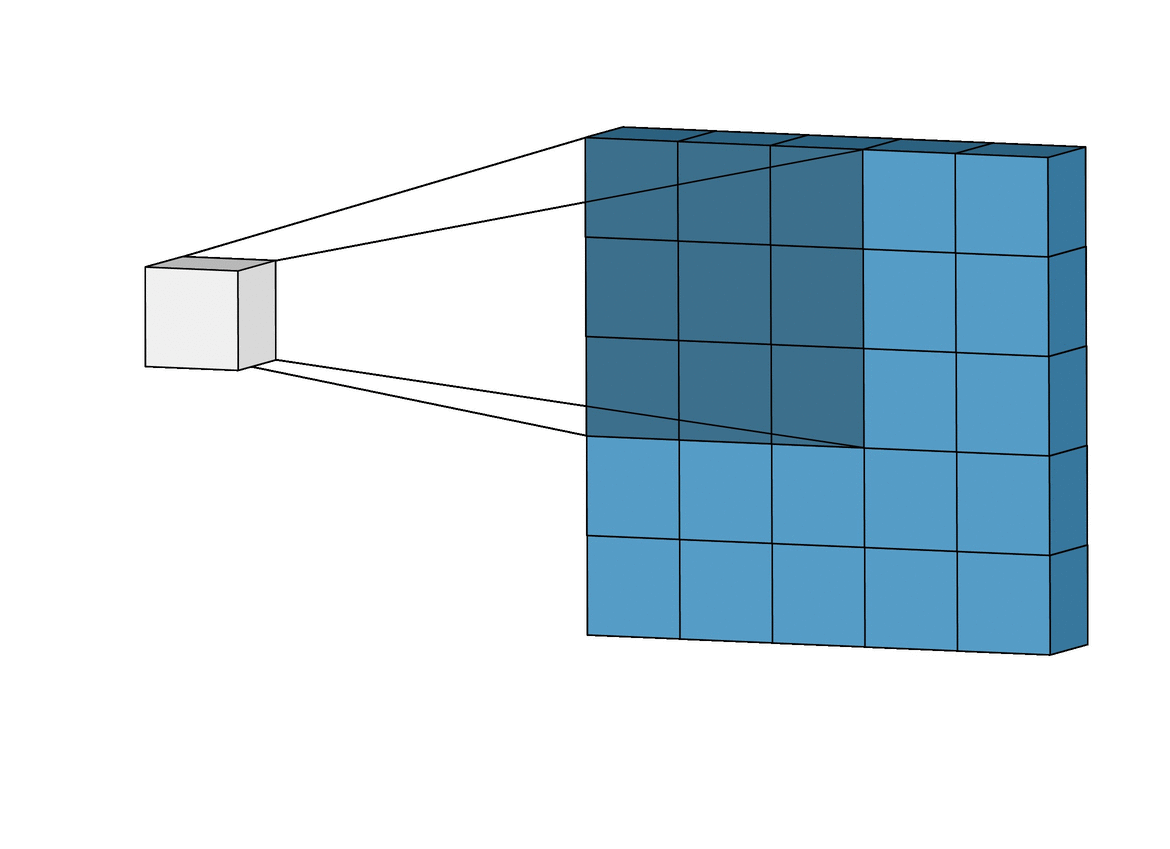
[link of gif](https://images.app.goo.gl/c1kC1Abu1T3NWhz8A)

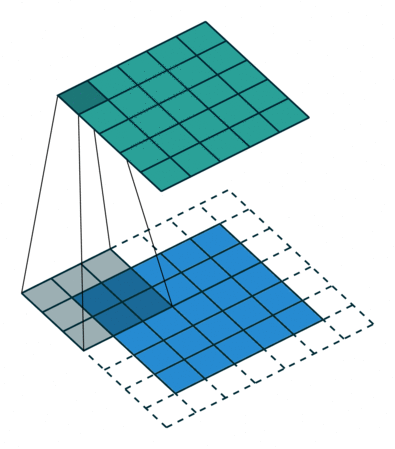
[link](https://images.app.goo.gl/NyvFNkUx6QaNnmtg6)

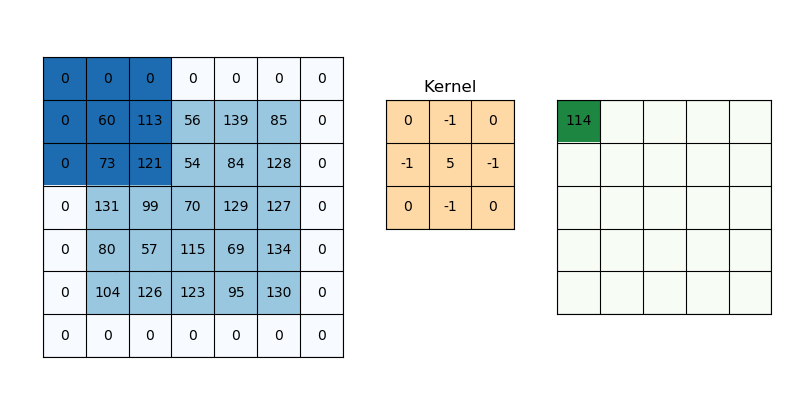
[link](https://images.app.goo.gl/h6hhLK43uc1weZyj8)

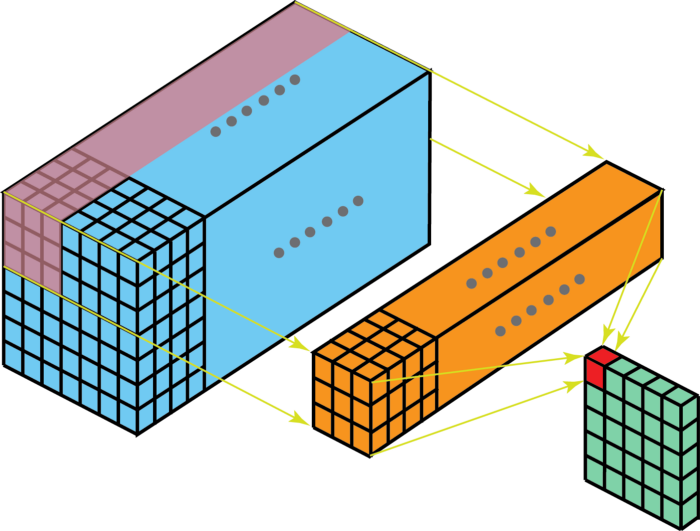
[link](https://towardsdatascience.com/a-comprehensive-introduction-to-different-types-of-convolutions-in-deep-learning-669281e58215)

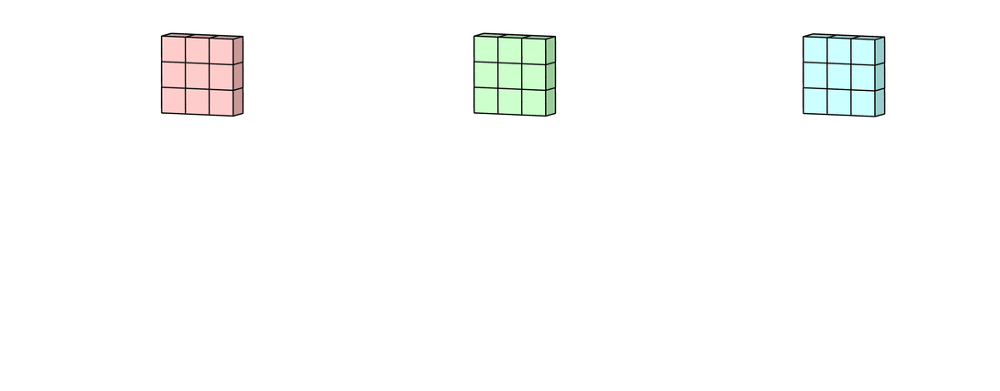
[link](https://images.app.goo.gl/trr4JFdTudfESMe19)

In [297]:
def create_ds_from_file(src):
    imgs, labels = [], []
    
    for label in range(10):
        path = src/str(label)
        print(path)
        t = [o.name for o in os.scandir(path)]
        t = _get_files(path, t, extensions = [".jpg", ".png"])
        for e in t:
            l = [np.array(Image.open(e)).reshape(28*28)]
            imgs += l
        labels += ([label] * len(t))
    return torch.tensor(imgs,  dtype=torch.float32), torch.tensor(labels, dtype=torch.long).view(-1,1)

In [298]:
trn_x, trn_y = create_ds_from_file(PATH/"train")

D:\python projects\lectures\102\NN from Scratch\data\mnist\train\0
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\1
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\2
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\3
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\4
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\5
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\6
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\7
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\8
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\9


In [299]:
val_x,val_y = create_ds_from_file(PATH/"validation")

D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\0
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\1
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\2
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\3
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\4
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\5
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\6
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\7
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\8
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\9


In [300]:
# there is little error here, can you spot it ?
mean = trn_x.mean()
std = trn_x.std()

trn_x=(trn_x-mean)/std
mean, std, trn_x.mean(), trn_x.std()

(tensor(34.3409), tensor(77.5014), tensor(7.4670e-06), tensor(1.))

In [301]:
val_x = (val_x-mean)/std
val_x.mean(), val_x.std()

(tensor(0.0042), tensor(1.0038))

In [302]:
class Dataset():
    def __init__(self, x, y): 
        self.x,self.y = x,y
    def __len__(self): 
        return len(self.x)
    def __getitem__(self, i): 
        return self.x[i].view(-1,1,28,28).cuda(),self.y[i].cuda()


class DataLoader():
    def __init__(self, ds, bs): 
        self.ds, self.bs = ds, bs
    def __iter__(self):
        n = len(self.ds)
        l = torch.randperm(n)

        
        for i in range(0, n, self.bs): 
            idxs_l = l[i:i+self.bs]
            yield self.ds[idxs_l]

In [303]:
train_ds = Dataset(trn_x, trn_y)
valid_ds = Dataset(val_x,val_y)

In [304]:
train_dl = DataLoader(train_ds, 256)
valid_dl = DataLoader(valid_ds, 256)

### Adding Customer Functions to nn.Sequential

In [305]:
import torch.nn.functional as F

In [306]:
class Func(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): 
        return self.func(x)

In [307]:
def flatten(x):      
    return x.view(x.shape[0], -1)

In [308]:
def print_t(x):      
    print(x.shape)
    return x

### CNN Model

* I am giving very basic cnn structure, please feel free to experiment on them. Add pooling, use different optimizers etc and try to increase the performance

In [313]:
model = nn.Sequential(
        nn.Conv2d(1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d(8, 16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16, 32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32, 32, 3, padding=1,stride=2), nn.ReLU(), # 2
        #Func(print_t),
        nn.AdaptiveAvgPool2d(1),
        Func(flatten),
        nn.Linear(32,10)
).cuda()

In [314]:
optim = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-3)

In [315]:
train(model,80,10)

0.09738372266292572
0.7789789438247681
0.8999818563461304
0.9304142594337463
0.9443132281303406
0.9553052186965942
0.9559411406517029
0.961755096912384
